## Figure 3: 

Evolution of (a) cyclone central pressure and eddy kinetic energy at (b) 300\,hPa and (c) 925\,hPa for simulations with no radiation (REF), cloud-radiative heating (CRH), and cloud-radiative heating increased by a factor of 2 (2xCRH).

---
@ Behrooz Keshtgar, KIT 2022

## 1- load python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import colorlegend
import warnings
warnings.filterwarnings("ignore")

For reference, print package versions to screen:

In [2]:
print('xarrary:   ', xr.__version__)
print('numpy:     ', np.__version__)
import matplotlib; print('matplotlib:', matplotlib.__version__); del matplotlib

xarrary:    0.16.0
numpy:      1.19.1
matplotlib: 3.3.0


## 2- Loading dataset

In [3]:
# Dictionary for loading simulations
simdict = {
         'LC1-channel-4000x9000km-2km-0002' : {'res':'2km', 'radiation':0, 'rh':0.8}, # No radiation
         'LC1-channel-4000x9000km-2km-0003' : {'res':'2km', 'radiation':1, 'rh':0.8}, # Cloud radiation
         'LC1-channel-4000x9000km-2km-0004' : {'res':'2km', 'radiation':1, 'rh':0.8}, # 2x Cloud radiation
             }

In [4]:
# loading 3d datasets
def load_simulations():
    ds_list = []
    for sim in list(simdict.keys()): 
        
        print('Working on loading data for', sim)
        # loading remapped datasets (0.5x0.5 r), interpolated from model height to pressure levels
        path = '/work/bb1135/from_Mistral/bb1135/b381185/output/LC1_Limited_channel/icon-v.2.6.2.2_2km/sim_list_output/'+sim+'_remapped_0.5x0.5/datasets_pres/'
        # different output naming 
        if sim in ['LC1-channel-4000x9000km-2km-0002' , 'LC1-channel-4000x9000km-2km-0003']:
            fname = path+'icon-fg*.nc'    
        else:
            fname = path+"icon-atm3d*.nc"                                                                       
        ds_var = xr.open_mfdataset(fname)[['u','v','temp','w']]
        ds_list.append(ds_var)
        del fname,ds_var

    return ds_list
#----------------------------------
ds_list = load_simulations()

Working on loading data for LC1-channel-4000x9000km-2km-0002
Working on loading data for LC1-channel-4000x9000km-2km-0003
Working on loading data for LC1-channel-4000x9000km-2km-0004


## 3- Deriving eddy kinetic energy at 300 & 925 hPa

In [5]:
# Function for calculating EKE at single levels

def eke_domain_mean(num,var1,var2,lev):
    # selection of pressure level and excluding north-south boundaries
    u1 = ds_list[num][var1].sel(plev_3 = lev,lat=slice(10,70))
    v1 = ds_list[num][var2].sel(plev_3 = lev,lat=slice(10,70))
    # zonal mean
    uzmean = u1.mean('lon',keep_attrs=True)
    vzmean = v1.mean('lon',keep_attrs=True)
    # eke
    eke = (0.5 *(np.power(u1-uzmean,2)+np.power(v1-vzmean,2)))
    # Domain mean
    ekedmean = eke.mean(dim=['lat','lon']).compute()
    return ekedmean

In [6]:
# deriving EKE at 300 and 925 hPa
eke_top = []
eke_down = []

for i in range(len(ds_list)):
    
    eke_300 = eke_domain_mean(i,'u','v',30000)
    eke_925 = eke_domain_mean(i,'u','v',92500)
    eke_top.append(eke_300)
    eke_down.append(eke_925)
    
    del eke_300, eke_925  

## 4- Deriving cyclone central pressure

In [7]:
# loading 2d datasets
def load_simulations():
    ds_list = []
    for sim in list(simdict.keys()): 
        
        print('Working on loading data for', sim)
        # loading remapped datasets (0.5x0.5 r)
        path = '/work/bb1135/from_Mistral/bb1135/b381185/output/LC1_Limited_channel/icon-v.2.6.2.2_2km/sim_list_output/'+sim+'_remapped_0.5x0.5/'
        fname = path+'icon-atm2d*.nc'                                                                     
        ds_var = xr.open_mfdataset(fname)[['pres_sfc']]
        ds_list.append(ds_var)
        del fname,ds_var

    return ds_list
#----------------------------------
ds_list_atm2d = load_simulations()

Working on loading data for LC1-channel-4000x9000km-2km-0002
Working on loading data for LC1-channel-4000x9000km-2km-0003
Working on loading data for LC1-channel-4000x9000km-2km-0004


In [8]:
# cyclone center pressure
for i in range(len(ds_list_atm2d)):
    
    # excluding north-south boundaries
    ds = ds_list_atm2d[i].sel(lat=slice(10,70))
    # cyclone core pressure and changing to hPa
    ds_list_atm2d[i]['pres_sfc_min'] = (ds['pres_sfc'].min(['lon','lat'])/1e2).compute()
    ds_list_atm2d[i]['pres_sfc_min'].attrs['units'] = 'hPa'
    # rate of change of cyclone core pressure
    ds_list_atm2d[i]['pres_sfc_min_dt'] = ds_list_atm2d[i]['pres_sfc_min'].diff(dim='time', label='upper')
    # lat-lon location of cyclone
    indlat = ds['pres_sfc'].argmin(['lon', 'lat'])['lat'].compute()
    indlon = ds['pres_sfc'].argmin(['lon', 'lat'])['lon'].compute()
    ds_list_atm2d[i]['pres_sfc_min_lat'] = ds['lat'][indlat]
    ds_list_atm2d[i]['pres_sfc_min_lon'] = ds['lon'][indlon]
    del ds, indlat, indlon

## 5- Plot

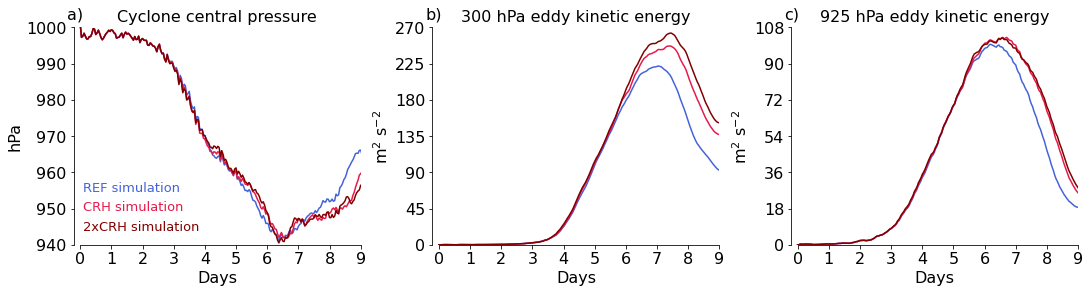

In [94]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

i = 0

for ax in axes.flat:
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    
    ax.spines['bottom'].set_bounds(0,216)
    ax.set_xticks(np.arange(0,217,24))
    ax.set_xticklabels(["0","1", "2", "3", "4", "5","6","7","8","9"])
    ax.set_xlim([-5, 216])
    
    ax.tick_params(labelsize=16)

    if i == 0:
        ax.plot(ds_list_atm2d[0]['pres_sfc_min'],'#4363d8',label="REF simulation",linewidth=1.5)
        ax.plot(ds_list_atm2d[1]['pres_sfc_min'],'#e6194B',label="CRH simulation",linewidth=1.5)
        ax.plot(ds_list_atm2d[2]['pres_sfc_min'],'#800000',label="2xCRH simulation",linewidth=1.5)
        lg=colorlegend.color_legend(ax,loc=3,fsize=13)
        
        ax.set_title('Cyclone central pressure',fontsize=16)
        ax.set_xlabel('Days',fontsize=16)
        ax.set_ylabel('hPa',fontsize=16)
        
        ax.spines['left'].set_bounds(940,1000)
        ax.set_yticks(np.arange(940,1010,10))
        ax.set_ylim([940, 1000])

        ax.text(-0.025, 1.04, 'a)', transform=ax.transAxes, size=16 )
        
    if i == 1:
        ax.plot(eke_top[0],'#4363d8',label="REF simulation",linewidth=1.5)
        ax.plot(eke_top[1],'#e6194B',label="CRH simulation",linewidth=1.5)
        ax.plot(eke_top[2],'#800000',label="2xCRH simulation",linewidth=1.5)

        ax.set_title('300 hPa eddy kinetic energy',fontsize=16)
        ax.set_xlabel('Days',fontsize=16)
        ax.set_ylabel('m$^2$ s$^{-2}$',fontsize=16)

        ax.spines['left'].set_bounds(0,270)
        ax.set_yticks(np.arange(0,300,45))
        ax.set_ylim([0, 270])

        ax.text(-0.025, 1.04, 'b)', transform=ax.transAxes, size=16 )
        
    if i == 2:
        ax.plot(eke_down[0],'#4363d8',label="REF simulation",linewidth=1.5)
        ax.plot(eke_down[1],'#e6194B',label="CRH simulation",linewidth=1.5)
        ax.plot(eke_down[2],'#800000',label="2xCRH simulation",linewidth=1.5)

        ax.set_title('925 hPa eddy kinetic energy',fontsize=16)
        ax.set_xlabel('Days',fontsize=16)
        ax.set_ylabel('m$^2$ s$^{-2}$',fontsize=16)

        ax.spines['left'].set_bounds(0,108)
        ax.set_yticks(np.linspace(0,108,7))
        ax.set_ylim([0, 108])
        
        ax.text(-0.025, 1.04, 'c)', transform=ax.transAxes, size=16 )    
        
    i = i + 1      

fig.subplots_adjust(wspace=0.25)

plt.savefig('figure3.pdf', bbox_inches = 'tight')